# Intent Classification

In [35]:
# import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras
from keras.layers import LSTM, Dropout, Dense, Activation, Flatten, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
import pickle

In [36]:
# read into csv file

df = pd.read_csv('train.csv')
df.head()

,sentence,BookRestaurant,GetWeather,PlayMusic,RateBook
0,book The Middle East restaurant in IN for noon,1,0,0,0
1,Book a table at T-Rex distant from Halsey St.,1,0,0,0
2,I'd like to eat at a taverna that serves chili...,1,0,0,0
3,I have a party of four in Japan and need a res...,1,0,0,0
4,Please make a restaurant reservation for somew...,1,0,0,0


In [37]:
# shuffle data
df = shuffle(df)
df.head()

,sentence,BookRestaurant,GetWeather,PlayMusic,RateBook
4562,Play a Jim Mullen ep from the sixties,0,0,1,0
4508,I want to hear a Gucci Mane song from Last Fm ...,0,0,1,0
5655,Play some nineties music on Zvooq,0,0,1,0
1539,I'd like to eat at a popular diner,1,0,0,0
1352,Where is Chips in Crouch,1,0,0,0


In [38]:
df.shape

(7929, 5)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7929 entries, 4562 to 7585
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentence        7929 non-null   object
 1   BookRestaurant  7929 non-null   int64 
 2   GetWeather      7929 non-null   int64 
 3   PlayMusic       7929 non-null   int64 
 4   RateBook        7929 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 371.7+ KB


In [40]:
df.isnull().sum()

sentence          0
BookRestaurant    0
GetWeather        0
PlayMusic         0
RateBook          0
dtype: int64

In [41]:
df['BookRestaurant'].value_counts()

0    5956
1    1973
Name: BookRestaurant, dtype: int64

In [42]:
df['GetWeather'].value_counts()

0    5929
1    2000
Name: GetWeather, dtype: int64

In [43]:
df['PlayMusic'].value_counts()       

0    5929
1    2000
Name: PlayMusic, dtype: int64

In [44]:
df['RateBook'].value_counts()   

0    5973
1    1956
Name: RateBook, dtype: int64

Data seems to be clean

In [45]:
X_train = df["sentence"].fillna("fillna").values
y_train = df[["BookRestaurant", "GetWeather", "PlayMusic", "RateBook"]].values

In [46]:
X_train.shape, y_train.shape

((7929,), (7929, 4))

In [47]:
X_train[1], y_train[1] 

('I want to hear a Gucci Mane song from Last Fm from 2002',
 array([0, 0, 1, 0], dtype=int64))

# Preprocessing

In [48]:
text = X_train

In [49]:
Tokenizer = Tokenizer()

In [50]:
# text preprocessing
Tokenizer.fit_on_texts(text) 
Tokenizer_vocab_size = len(Tokenizer.word_index)+1
Tokenizer_vocab_size

7522

In [51]:
X_train.shape, y_train.shape

((7929,), (7929, 4))

In [52]:
samples = 2500

X_train = X_train[samples:] 
y_train = y_train[samples:] 

X_val = X_train[:samples] 
y_val = y_train[:samples] 

In [53]:
X_train.shape, y_train.shape

((5429,), (5429, 4))

In [54]:
X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)  # refer: https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)

In [55]:
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = 100)  # refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = 100)

X_train_encoded_padded_words.shape, X_val_encoded_padded_words.shape

((5429, 100), (2500, 100))

In [56]:
X_val_encoded_padded_words, X_train_encoded_padded_words

(array([[   0,    0,    0, ...,  234,   13,   41],
        [   0,    0,    0, ...,  824,   14,  186],
        [   0,    0,    0, ...,  166,    5,  460],
        ...,
        [   0,    0,    0, ...,    3,  111,  234],
        [   0,    0,    0, ..., 5737, 1223, 2248],
        [   0,    0,    0, ...,  104,   14,  134]]),
 array([[   0,    0,    0, ...,  234,   13,   41],
        [   0,    0,    0, ...,  824,   14,  186],
        [   0,    0,    0, ...,  166,    5,  460],
        ...,
        [   0,    0,    0, ...,    5,   11,   32],
        [   0,    0,    0, ...,  139,    3, 7518],
        [   0,    0,    0, ..., 7521,    1,   45]]))

In [57]:
y_train.shape, y_val.shape

((5429, 4), (2500, 4))

# Build and Train the Model

In [58]:
model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 32, input_length = 100))  # refer: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(120, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           240704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               4400      
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1604      
Total params: 248,428
Trainable params: 248,428
Non-trainable params: 0
________________________________________________

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
history  = model.fit(X_train_encoded_padded_words,y_train, epochs = 3, batch_size=32, verbose=1, validation_data=(X_val_encoded_padded_words, y_val))

Epoch 1/3
170/170 [==============================] - 7s 25ms/step - loss: 1.1077 - accuracy: 0.5361 - val_loss: 0.3500 - val_accuracy: 0.7752
Epoch 2/3
170/170 [==============================] - 4s 21ms/step - loss: 0.3365 - accuracy: 0.8168 - val_loss: 0.0155 - val_accuracy: 0.9980
Epoch 3/3
170/170 [==============================] - 4s 22ms/step - loss: 0.1014 - accuracy: 0.9592 - val_loss: 0.0041 - val_accuracy: 0.9992


# Plots

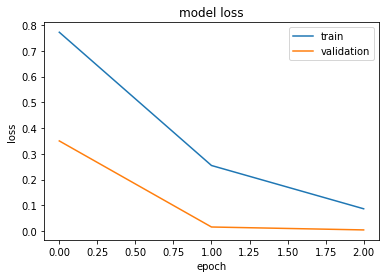

In [61]:
#loss
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

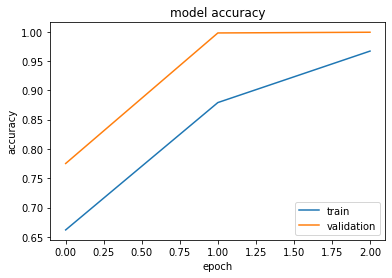

In [62]:
#accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# Loss and Accuracy 

In [63]:
model.evaluate(X_val_encoded_padded_words, y_val)

79/79 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 0.9992


[0.004116282798349857, 0.9991999864578247]

# Predictions 

In [76]:
# save the model and tokenizer
pickle.dump(Tokenizer, open('models/tokenizer.pkl','wb'))
model.save("models/Intent_Classification.h5")

In [77]:
# load the saved model  and tokenizer
saved_model = keras.models.load_model('models/Intent_Classification.h5')
Tokenizer = pickle.load(open('models/tokenizer.pkl','rb'))

In [78]:
def predict(text):
    sentence = text
    tokens = Tokenizer.texts_to_sequences([text])
    tokens = pad_sequences(tokens, maxlen = 100)
    prediction = saved_model.predict(np.array(tokens))
    pred = np.argmax(prediction)
    classes = ['BookRestaurant','GetWeather','PlayMusic','RateBook']
    result = classes[pred]
    return pred,result

In [79]:
predict("is it raining ?")

(1, 'GetWeather')

In [80]:
predict("i would like to book a table at hotel Orion for 29th june")

(0, 'BookRestaurant')

In [81]:
predict("Arjith Singh's music album released")

(2, 'PlayMusic')

In [82]:
predict("this novel deserves a rating of 10")

(3, 'RateBook')

Medium Article: https://medium.com/ai-techsystems/intent-classification-using-lstm-5067d283c10a